# Extract abstract and corpus
Defined variables:
* site: url link to site

Output variables:
* original_abstract: abstract sentence list
* original_corpus: corpus sentence list
* clean_abstract: remove stopwords, lowercased, punctuation, etc. cleaned sentence list of abstract
* clean_corpus: cleaned corpus, list of sentences

Note: original and cleaned versions should have same length, for consistency.
Note each sentence is itself list of words.

NOTE: run sci-spacy and pip installs first, which require runtime restarting, and may override glove etc. imports

In [0]:
import numpy as np
import pandas as pd
import re

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
def read_file(filename):
  """
  Obtains original text in filename, in sentence list form.
  """
  reader = open(filename)
  text = ''
  for line in reader:
    text += line + '\n'

  #obtain a sentence list of the original text (abstract or corpus)
  original_text = text.strip().split('.')
  return original_text

In [0]:
def clean_text(original_text, sentence_length_cutoff=5):
  """
  obtain a clean sentence list of original_text
  no punctuation, lowercase, no stop words, and no short sentences
  """
  clean_text = []
  for sentence in original_text:
    sentence = sentence.lower()
    sentence = re.sub("[^a-zA-Z0-9.]", " ", sentence)
    sentence = sentence.split()
    sentence_no_stopwords = [word for word in sentence if word not in stop_words]
    if len(sentence_no_stopwords) < sentence_length_cutoff:
      sentence_no_stopwords = [] #treat it as an empty sentence.
      #we still need something there for a placeholder, for indexing.
    clean_text.append(sentence_no_stopwords)
  return clean_text


In [0]:
#note the length is the same between original versus cleaned.
original_abstract = read_file('abstract_1.txt')
clean_abstract = clean_text(original_abstract)

In [0]:
original_corpus = read_file('corpus_1.txt')
clean_corpus = clean_text(original_corpus)

# Apply GloVe to a corpus
Defined variables:
* clean_corpus

Output variables:
* glove_summary, a list of (score, original sentence, clean sentence, index) sorted highest to lowest score

Note: we can use index to find corresponding clean_corpus sentences if desired.

In [0]:
# download GloVe
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2020-04-26 01:33:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-04-26 01:33:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-04-26 01:33:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [0]:
# store a dictionary of word to corresponding GloVe vector
word_to_vec = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_to_vec[word] = coefs
f.close()

## Vectorize corpus
Output
* vec_corpus, list of vectors. 1 vector for each sentence.

In [0]:
def vectorize_word(w):
  """
  Returns the 100-dimension GloVe vector for a word, or zero vector if not found.
  """
  return word_to_vec.get(w, np.zeros((100,)))

In [0]:
def vectorize_summary(clean_sentence_list):
  """
  Returns a list of vectors, where each vector represents the vector of a sentence.
  The vector of each sentence is the mean of the vectors of the words in the sentence.
  """
  vec_sentences = []
  for sentence in clean_sentence_list:
    vec_sentences.append(np.mean(
        np.array([vectorize_word(w) for w in sentence])
        , axis=0))
  return vec_sentences

In [0]:
vec_glove_corpus = vectorize_summary(clean_corpus)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Obtain Similarity Matrix
Input
* vec_glove_corpus or vec_cui_corpus

Output
* matrix_glove_corpus or matrix_cui_corpus: similarity matrix of vec_glove_corpus

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
def get_sim_matrix(vec_sentences, vec_length):
  """
  vec_length is 100 for gloVe, and 500 for Cui2vec
  """
  similarity_matrix = np.zeros(
      [len(vec_sentences), len(vec_sentences)], dtype=float)
  #two perpendicular vectors have 0 similarity, because cosine of 90 is 0.

  for i in range(len(vec_sentences)):
    for j in range(len(vec_sentences)):
      if i != j:
          if np.isnan(np.sum(vec_sentences[i])) or np.isnan(np.sum(vec_sentences[j])):
            similarity_matrix[i][j] = 0
            #one of them is nan
          else:
            similarity_matrix[i][j] = cosine_similarity(
                vec_sentences[i].reshape(1,vec_length), # because 100 dimension GloVe vector
                vec_sentences[j].reshape(1,vec_length))[0,0]
  return similarity_matrix

In [0]:
matrix_glove_corpus = get_sim_matrix(vec_glove_corpus, 100)

# Perform TextRank
Input:
* matrix_glove_corpus, or matrix_cui_corpus
* original_corpus
* clean_corpus

Output:
* glove_summary, or cui_summary

In [0]:
import networkx as nx

In [0]:
def textrank(sim_matrix, original_text, clean_text, top_n=5):
  """
  Get the top_n sentences via textrank on the sim_matrix
  select corresponding text from original_text (uncleaned sentence list)
  """
  graph = nx.from_numpy_array(sim_matrix)
  scores = nx.pagerank(graph) #each of the sentences, and corresponding score

  ranked_sentences = sorted((
      (scores[i],orig_sentence, clean_text[i], i) for i,orig_sentence in enumerate(original_text)), 
      reverse=True)
  print("Summary:")
  for i in range(top_n):
    print (ranked_sentences[i][1].strip()) #just print the sentence for viewing
    #some original sentences still had \n attached, so strip
  return ranked_sentences


In [0]:
top_n = 5#len(original_abstract) #or 5

In [0]:
glove_summary = textrank(matrix_glove_corpus, original_corpus, clean_corpus, top_n=top_n)

Summary:
Bacterial strains for the positive and negative controls were fixed as described elsewhere [30] and were included in each FISH experiment to control the probe specificity and sensitivity
urinae described in this paper, we now have at our disposal a test system for further research and diagnostics for culture-negative heart valves that enables rapid and specific species identification and targeted antibiotic therapy
The direct detection of microorganisms in valve specimens by FISH enables the simultaneous visualization and identification of the causative agent in situ, also in culture-negative cases [5]
Reasons for culture-negative results may include biofilm growth, previous antibiotic treatment and/or rare or slow-growing bacterial species that are missed by routine culture methods
We analyzed heart valve samples from two IE patients in whom routine culture methods did not immediately correctly identify the key causative pathogen


# Apply Cui2Vec to a Corpus

Defined variables:
* clean_corpus

Output variables:
* cui_summary

## Install scispacy

In [0]:
!pip install scispacy

     |████████████████████████████████| 3.0MB 4.5MB/s 
     |████████████████████████████████| 13.0MB 324kB/s 
     |████████████████████████████████| 6.1MB 45.3MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 296kB 50.5MB/s 
  Created wheel for scispacy: filename=scispacy-0.2.4-cp36-none-any.whl size=35204 sha256=8c719ea1242c474d0974f494283068bb875ad1dc86fdf33d3bc5dd8ba6bc29cb
  Stored in directory: /root/.cache/pip/wheels/36/5e/7c/ba8d6b02f5cfa40735e40ccffd29852ca19ebca59393afd5f0
Successfully built scispacy
  Found existing installation: botocore 1.15.43
    Uninstalling botocore-1.15.43:
      Successfully uninstalled botocore-1.15.43
  Found existing installation: rsa 4.0
    Uninstalling rsa-4.0:
      Successfully uninstalled rsa-4.0


In [0]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

In [0]:
!pip install -U spacy

In [0]:
import spacy
import scispacy
import en_core_sci_sm   #The model we are going to use
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker

In [0]:
nlp_reader = en_core_sci_sm.load()
cui_linker = UmlsEntityLinker(resolve_abbreviations=True)
nlp_reader.add_pipe(cui_linker) # Each entity is linked to UMLS with a score# (currently just char-3gram matching).

## Load cui2vec

In [0]:
!wget https://ndownloader.figshare.com/files/10959626?private_link=00d69861786cd0156d81 -O cui2vec_pretrained.csv.zip

In [0]:
!unzip cui2vec_pretrained.csv.zip #or try taking out the .zip

Archive:  cui2vec_pretrained.csv.zip
  inflating: cui2vec_pretrained.csv  
   creating: __MACOSX/
  inflating: __MACOSX/._cui2vec_pretrained.csv  


In [0]:
import numpy as np
import pandas as pd
embeddings = pd.read_csv("cui2vec_pretrained.csv")

In [0]:
def word_list_to_sent_list(clean_text):
  """
  converts to format where each entry of list is a sentence
  """
  output = []
  for sentence in clean_text:
    if len(sentence) == 0:
      output.append('')
    else:
      output.append(' '.join(sentence))
  return output

## Find entities in each sentence

In [0]:
def clean_sent_list_to_ent_list(clean_sentence_list):
  """
  Takes clean sentence list, such as ['sentence is here', 'sentence is here'].
  Note this isn't quite the same as clean_corpus, where each sentence is further a list of words.
  """
  sent_list = []
  for s in clean_sentence_list:
    sent_list.append(list(nlp_reader(s).ents)) #might be blank.
  return sent_list

## Entity to vector

In [0]:
def ent_to_vec(entity, cap = 3):
  vecsum = np.zeros((500,))
  maxrange = min(cap, len(entity._.umls_ents))
  for i in range(maxrange):
    cuii, scorei = entity._.umls_ents[i]
    v = cui_to_vec(cuii)
    vecsum += scorei*v
  if maxrange > 0:
    return vecsum/maxrange 
  return np.zeros((500,)) # if maxrange is 0, then just return
  #return np.mean(vecs, axis=0)

## Convert a cui to vector representation

In [0]:
def cui_to_vec(cui):
  cui = str(cui).upper()
  s = embeddings.loc[embeddings['Unnamed: 0'] == cui] #make sure to run embeddings = pd.read_csv...
  vec = s.drop("Unnamed: 0", axis=1)
  if s.shape[0] == 0: #if not available cui, then return 0 (i.e. 0 rows)
    return np.zeros((500,))
  return np.array(vec).ravel()

## Convert sentence list to vector list

In [0]:
def entList_to_vec(ent_list):
 # if len(ent_list) == 0:
  #  return np.zeros()
  outputsum = np.zeros((500,))
  nonzero_count = 0
  for ent in ent_list:
    v = ent_to_vec(ent)
    if np.sum(v) == 0:
      continue
    nonzero_count += 1
    outputsum += v
  if nonzero_count == 0:
    return np.zeros((500,))
  return outputsum/nonzero_count

In [0]:
def sentList_to_vecList(sent_list):
  vec_list = []
  for ent_list in sent_list:
    vec_list.append(entList_to_vec(ent_list))
  return vec_list

In [0]:
entity_list_list = clean_sent_list_to_ent_list(word_list_to_sent_list(clean_corpus))

In [0]:
vec_cui_corpus = sentList_to_vecList(entity_list_list)

## Similarity Matrix

In [0]:
matrix_cui_corpus = get_sim_matrix(vec_cui_corpus, 500)

## Perform TextRank

In [0]:
top_n = 5#len(original_abstract) # can use 5

In [0]:
cui_summary = textrank(matrix_cui_corpus, original_corpus, clean_corpus, top_n=top_n)

Summary:
FISH on sections of the mitral valve tissue simultaneously using the probes AURI (Cy3-labeled), EUB338 (FITC-labeled), NONEUB (Cy5), and the nucleic acid stain DAPI (blue) identified the infectious agent in situ as A
FISH reveals impressive biofilms on the mitral heart valve from the first patient, identifying the infectious agent as Aerococcus urinae
urinae blood culture isolate from a patient not related to the cases presented here served as a positive control
In recent years molecular biological methods such as nucleic acid amplification techniques (NAT) and fluorescence in situ hybridization (FISH) have helped detect microorganisms that might otherwise be missed by routine culture methods [4]
FISH reveals Aerococcus urinae infiltrating the aortic heart valve from the second patient


# Evaluate summary against abstract
Defined variables:
* original_abstract
* clean_abstract
* glove_summary
* cui_summary

Output variables:

ROUGE n-gram implementation

## Direct comparison by eye

In [0]:
top_n = 5#len(original_abstract)

In [0]:
def direct_comparison(summary, abstract, top_n=5):
  summary_string = ''
  for _,_,_,i in summary[0:top_n]:
    summary_string += original_corpus[i].strip() + '. '
  abstract_string = '. '.join(abstract)
  return summary_string, abstract_string

In [0]:
s_cui,a = direct_comparison(cui_summary, original_abstract, top_n=top_n)

In [0]:
print(s_cui) #print generated summary

FISH on sections of the mitral valve tissue simultaneously using the probes AURI (Cy3-labeled), EUB338 (FITC-labeled), NONEUB (Cy5), and the nucleic acid stain DAPI (blue) identified the infectious agent in situ as A. FISH reveals impressive biofilms on the mitral heart valve from the first patient, identifying the infectious agent as Aerococcus urinae. urinae blood culture isolate from a patient not related to the cases presented here served as a positive control. In recent years molecular biological methods such as nucleic acid amplification techniques (NAT) and fluorescence in situ hybridization (FISH) have helped detect microorganisms that might otherwise be missed by routine culture methods [4]. FISH reveals Aerococcus urinae infiltrating the aortic heart valve from the second patient. 


In [0]:
print(a) #print abstract

The diagnosis of infective endocarditis (IE) remains a challenge.  One of the rare bacterial species recently associated with biofilms and negative cultures in infective endocarditis is Aerococcus urinae.  Whether the low number of reported cases might be due to lack of awareness and misidentification, mainly as streptococci, is currently being discussed.  To verify the relevance and biofilm potential of Aerococcus in endocarditis, we used fluorescence in situ hybridization to visualize the microorganisms within the heart valve tissue.  We designed and optimized a specific FISH probe (AURI) for in situ visualization and identification of A.  urinae in sections of heart valves from two IE patients whose 16S rRNA gene sequencing had deteced A.  urinae.  Both patients had a history of urinary tract infections.  FISH visualized impressive in vivo grown biofilms in IE, thus confirming the potential of A.  urinae as a biofilm pathogen.  In both cases, FISH/PCR was the only method to unequivo

In [0]:
s_glove,a = direct_comparison(glove_summary, original_abstract)

In [0]:
print(s_glove)

Bacterial strains for the positive and negative controls were fixed as described elsewhere [30] and were included in each FISH experiment to control the probe specificity and sensitivity. urinae described in this paper, we now have at our disposal a test system for further research and diagnostics for culture-negative heart valves that enables rapid and specific species identification and targeted antibiotic therapy. The direct detection of microorganisms in valve specimens by FISH enables the simultaneous visualization and identification of the causative agent in situ, also in culture-negative cases [5]. Reasons for culture-negative results may include biofilm growth, previous antibiotic treatment and/or rare or slow-growing bacterial species that are missed by routine culture methods. We analyzed heart valve samples from two IE patients in whom routine culture methods did not immediately correctly identify the key causative pathogen. 


## Rouge

In [0]:
!pip install easy-rouge

In [0]:
from rouge.rouge import rouge_n_summary_level

In [0]:
def clean_summary_only(summary, top_n=5):
  """
  Extract only the clean summary sentences
  summary: [ (score, orig sentence, clean sentence, index), ...]
  """
  top_n = min(top_n, len(summary))
  return [summary[i][2] for i in range(top_n)]

In [0]:
def flatten_sentence_list(sentence_list):
  """
  joins all the words in sentence list into a single string
  """
  output = ''
  for sentence in sentence_list:
    output += ' '.join(sentence) + '. '
  return output

In [0]:
def rouge(summary, abstract):
  # make sure theyre flattened to a single string
  flat_summary = flatten_sentence_list(summary)
  flat_abstract = flatten_sentence_list(abstract)
  recall, precision, fscore = rouge_n_summary_level(flat_summary, flat_abstract, 1)
  print('ROUGE-1-R', recall)
  print('ROUGE-1-P', precision)
  print('ROUGE-1-F', fscore)

In [0]:
# get the summary words only
clean_cui_summary = clean_summary_only(cui_summary)
clean_glove_summary = clean_summary_only(glove_summary)

In [0]:
# apply rouge to compare
rouge(clean_cui_summary, clean_abstract)

ROUGE-1-R 0.6652806652806653
ROUGE-1-P 0.9815950920245399
ROUGE-1-F 0.7930607187112764


In [0]:
rouge(clean_glove_summary, clean_abstract)

ROUGE-1-R 0.762993762993763
ROUGE-1-P 0.9852348993288591
ROUGE-1-F 0.8599882835383714


## Histogram of scores

In [0]:
import matplotlib.pyplot as plt

In [0]:
# how many are zeros (e.g. in matrix also)

In [0]:
def scores(summary):
  return [summary[i][0] for i in range(len(summary))]

In [0]:
cui_scores = scores(cui_summary)
glove_scores = scores(glove_summary)

(array([71.,  1.,  0.,  0.,  5.,  5., 14., 15., 52., 57.]),
 array([0.00093998, 0.00158047, 0.00222095, 0.00286144, 0.00350193,
        0.00414242, 0.00478291, 0.0054234 , 0.00606389, 0.00670437,
        0.00734486]),
 <a list of 10 Patch objects>)

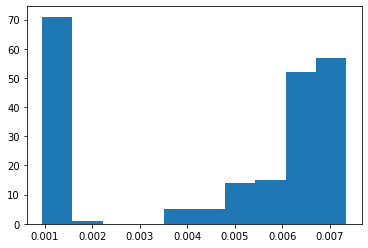

In [0]:
plt.hist(glove_scores)

(array([79.,  2.,  5.,  4., 15., 23., 24., 37., 23.,  8.]),
 array([0.00091479, 0.00177085, 0.0026269 , 0.00348295, 0.00433901,
        0.00519506, 0.00605112, 0.00690717, 0.00776322, 0.00861928,
        0.00947533]),
 <a list of 10 Patch objects>)

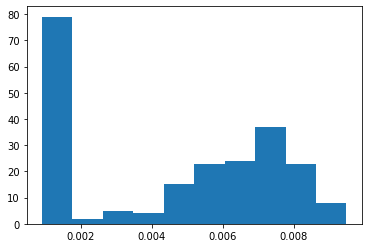

In [0]:
plt.hist(cui_scores)

## Matrix visualization
Input:
* matrix_text (matrix_glove_corpus, matrix_cui_corpus)

In [0]:
import matplotlib.pyplot as plt

In [0]:
def visualize_matrix(matrix_text, remove_blank_sentences=True):
  """
  Plots similarity matrix of sentence vectors.
  Option to remove blank sentences with 0 similarity.
  """
  if not remove_blank_sentences:
    plt.matshow(matrix_text, cmap=plt.cm.Blues)
    plt.show()
    return

  # remove all the zero'd sentences
  no_zero_mat = matrix_text[~np.all(matrix_text == 0, axis=1)]
  no_zero_mat = no_zero_mat[:,~np.all(no_zero_mat == 0, axis=0)]
  plt.matshow(no_zero_mat, cmap=plt.cm.Blues)
  plt.show()

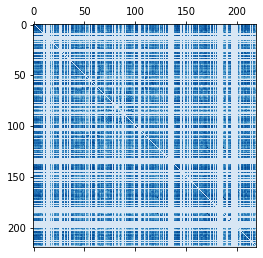

In [0]:
visualize_matrix(matrix_glove_corpus, remove_blank_sentences=False)

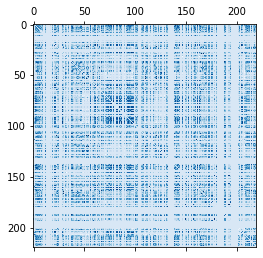

In [0]:
visualize_matrix(matrix_cui_corpus, remove_blank_sentences=False)

# Additional notes
* why sentence importance and length are correlated

In [0]:
def plot_length_vs_importance(summary):
  y = [(stc[0], len(stc[1])) for stc in summary]
  plt.scatter(*zip(*y))
  plt.xlabel("Importance Score")
  plt.ylabel("Sentence Length (chars)")
  plt.show()

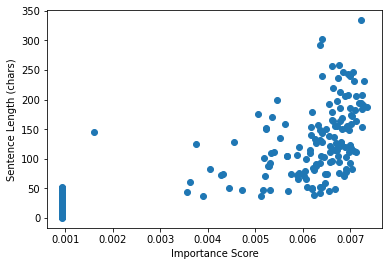

In [0]:
plot_length_vs_importance(glove_summary)

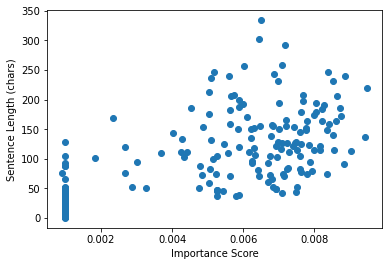

In [0]:
plot_length_vs_importance(cui_summary)